In [24]:
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
torch.hub.set_dir("D:\\ASL_RECOGNITION\\.cache")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [27]:
# Load and preprocess image
image_path = "./2_CLASS_DS/test/1/IMG_20240902_143632_Burst01.jpg"
image = Image.open(image_path)
transform = T.ToTensor()
img = transform(image)

# Run inference
with torch.no_grad():
    pred = model([img])

# Extract predictions
bboxes, labels, scores = pred[0]["boxes"], pred[0]["labels"], pred[0]["scores"]
num = torch.sum(scores > 0.9).item()
names = ["hand"]

Bounding box 1: 634, 652, 2288, 4100


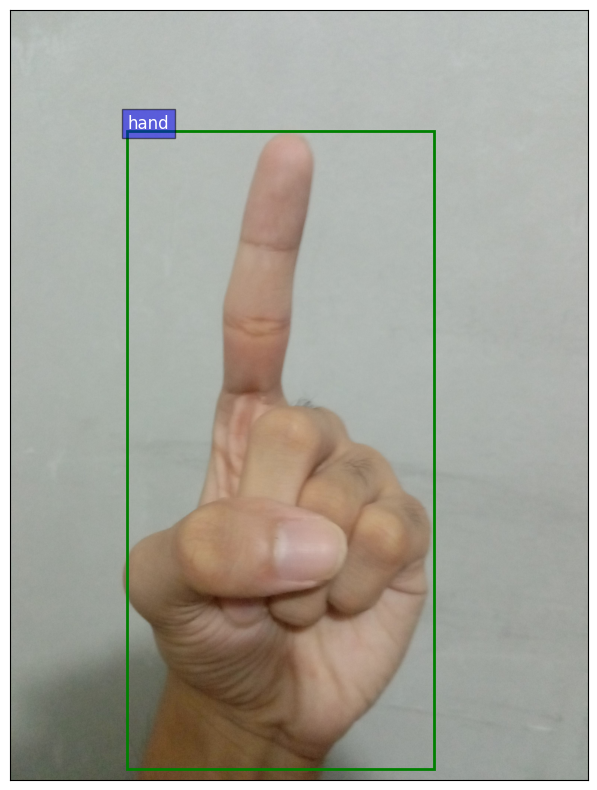

In [28]:
# Convert image to numpy array for matplotlib
igg = np.array(image)

# Create figure and axis
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(igg)

# Draw bounding boxes and labels
for i in range(num):
    x1, y1, x2, y2 = bboxes[i].numpy().astype(int)
    print(f"Bounding box {i+1}: {x1}, {y1}, {x2}, {y2}")
    class_name = names[labels[i].item() - 1]
    
    # Create a Rectangle patch
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)
    
    # Add label
    ax.text(x1, y1 - 10, class_name, bbox=dict(facecolor='blue', alpha=0.5), fontsize=12, color='white')

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.tight_layout()
plt.show()